# Preliminary stuff

In [13]:
import numpy as np
import pandas as pd
from collections import Counter
import networkx as nx
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, ttest_1samp, pearsonr, kendalltau
import matplotlib
import statsmodels.formula.api as smf
from matplotlib.patches import Rectangle
import matplotlib.transforms as transforms
from nilearn import surface, plotting
from graphs import (
    modular,
    ring_lattice,
    graph_df,
    subjects,
    subjects_lattice,
    subjects_modular
)
from roi_loader import Loader
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 12})
# %config InlineBackend.figure_format = 'retina'
# matplotlib.rcParams.update({'font.sans-serif': "Helvetica"})
# matplotlib.rcParams.update({'font.serif': "Times"})
%matplotlib inline
# %config InlineBackend.figure_format='retina' 

In [14]:
project_dir = os.path.expanduser('~/GraphLearn')
data_dir = f'{project_dir}/data'
loader = Loader(project_dir)

## Load MVPA Results

Results are saved as dataframes, indexed by:

**classifier**:
What the analysis attemped to classify

**rescale**: Whether each parameter estimate was scaled to 0

**subtract_mean**: Zero-center parameter estimates for each voxel within a block

In [15]:
classifier_names = (
    'node',
)

In [16]:
rois = (
    'postcentral-lh',
    'postcentral-rh',
    'postcentral-both',
    'precentral-lh',
    'precentral-rh',
    'precentral-both',
    'loc-localized',
    'loc-localized-lh',
    'loc-localized-rh',
    'hippocampus-lh',
    'hippocampus-rh',
    'hippocampus-both',
    'entorhinal-lh',
    'entorhinal-rh',
    'entorhinal-both',
)

In [17]:
pe_params = [
    (True, True),
]

In [18]:
results_list = []
mvpa_dir = 'mvpa_classifier'
for rescale, subtract_mean in pe_params:
    for roi in rois:
        print(f'Loading {roi}...')
        for classifier in classifier_names:
            print(f'Loading {classifier}...')
            for subject in subjects:
                df = pd.read_csv(f'{project_dir}/derived/{mvpa_dir}/sub-{subject}/sub-{subject}_rescale-{rescale}_subtract-mean-{subtract_mean}_zstats_{roi}_predictions-{classifier}.csv.gz', index_col=0)
                df['classifier'] = classifier
                df['roi'] = roi
                df['subtract_mean'] = subtract_mean
                df['rescale'] = rescale
                results_list.append(df)
print('Done')

Loading postcentral-lh...
Loading node...
Loading postcentral-rh...
Loading node...
Loading postcentral-both...
Loading node...
Loading precentral-lh...
Loading node...
Loading precentral-rh...
Loading node...
Loading precentral-both...
Loading node...
Loading loc-localized...
Loading node...
Loading loc-localized-lh...
Loading node...
Loading loc-localized-rh...
Loading node...
Loading hippocampus-lh...
Loading node...
Loading hippocampus-rh...
Loading node...
Loading hippocampus-both...
Loading node...
Loading entorhinal-lh...
Loading node...
Loading entorhinal-rh...
Loading node...
Loading entorhinal-both...
Loading node...
Done


In [19]:
results = pd.concat(results_list)
n_features_list = ['0', '10', '20', '50', '100', '200', '400', '600', '800']
results['voxels'] = pd.Categorical(results['voxels'].astype('Int16').fillna(0).astype(str), n_features_list)

## Verify Graph assignments

In [20]:
# results = results_loc[('node', True, True)]
m_subjects = results[results['graph'] == 'Modular']['subject'].unique()
l_subjects = results[results['graph'] == 'Lattice']['subject'].unique()
print(f'Modular: {len(m_subjects)}')
print(f'Lattice: {len(l_subjects)}')

Modular: 16
Lattice: 15


The first set should all look like Modular assignments

The second set should all look like Lattice assignments

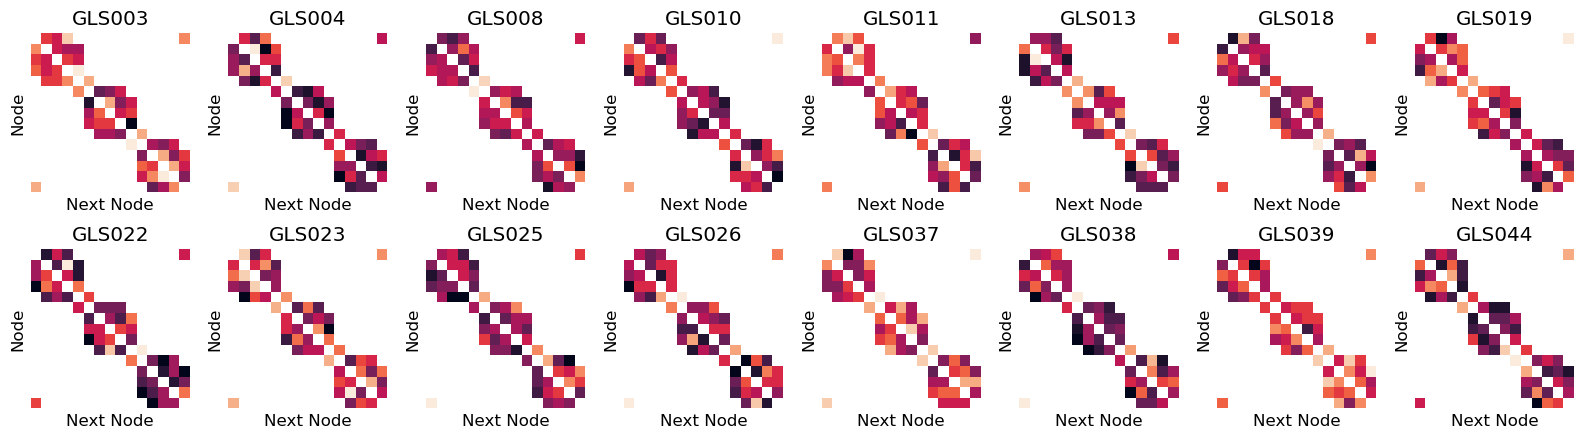

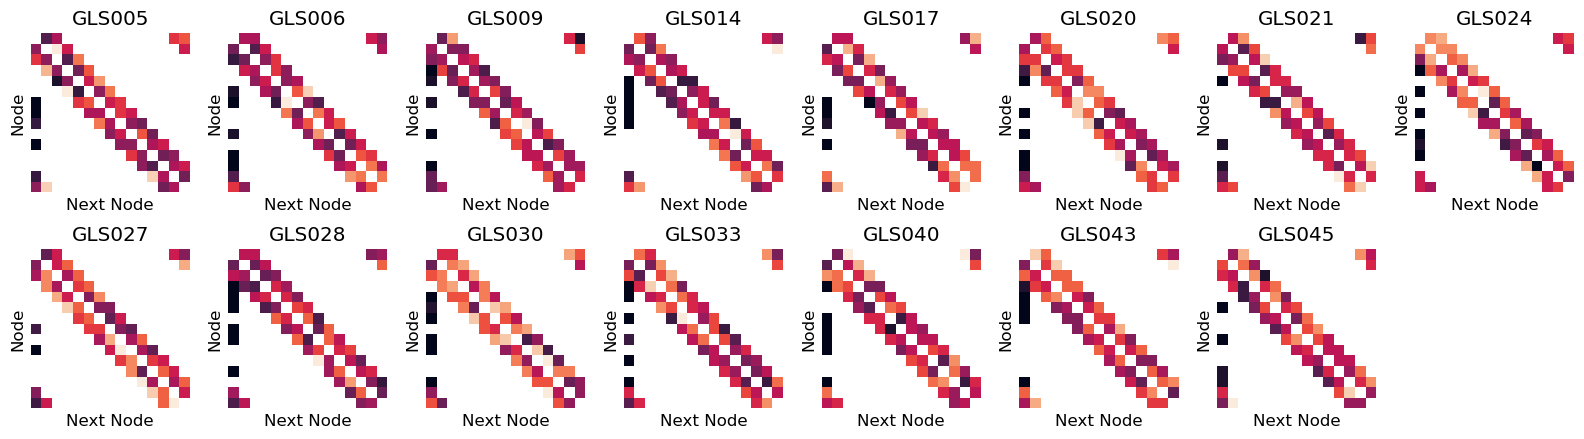

In [13]:
f, ax = plt.subplots(2, 8, figsize=(16, 4.5))
ax = ax.flatten()
for i, subject in enumerate(m_subjects):
    subset = results[(results['subject'] == subject)]
    transition_matrix = subset.groupby(['node', 'node_next'])['subject'].count().unstack()
    sns.heatmap(transition_matrix, ax=ax[i], square=True, cbar=False, xticklabels=False, yticklabels=False)
    ax[i].set_xlabel('Next Node')
    ax[i].set_ylabel('Node')
    ax[i].set_title(subject)
# Remove extra axes
for j in range(i + 1, len(ax)):
    f.delaxes(ax[j])
f.tight_layout()
f.savefig('images/transition_verification_modular.pdf')

f, ax = plt.subplots(2, 8, figsize=(16, 4.5))
ax = ax.flatten()
for i, subject in enumerate(l_subjects):
    subset = results[(results['subject'] == subject)]
    transition_matrix = subset.groupby(['node', 'node_next'])['subject'].count().unstack()
    sns.heatmap(transition_matrix, ax=ax[i], square=True, cbar=False, xticklabels=False, yticklabels=False)
    ax[i].set_xlabel('Next Node')
    ax[i].set_ylabel('Node')
    ax[i].set_title(subject)
# Remove extra axes
for j in range(i + 1, len(ax)):
    f.delaxes(ax[j])
f.tight_layout()
f.savefig('images/transition_verification_lattice.pdf')

# Behavior

Tuples of classifier name, and chance performance.


Here 'node' is predicting the current node based on our BOLD data,
and we expect chance to be a random guess with 15 stimuli, or 1 / 15

In [21]:
classifiers = [
    ('node', 1/15.0),
]

Some shortcuts to load dataframes of data for:
1. Session one learning: `session_one`
2. Session one recall: `session_checks`
3. session two recall: `sessions_two`

In [22]:
session_one = loader.load_session_one(subjects)
session_two = loader.load_session_two(subjects)
session_checks = loader.load_checks(subjects)

tag which trials are cross-cluster

In [23]:
is_modular = session_one['graph'] == 'Modular'
cluster_1 = is_modular & (session_one['node'] < 5)
cluster_2 = is_modular & (session_one['node'] > 4) & (session_one['node'] < 10)
cluster_3 = is_modular & (session_one['node'] > 9)

session_one['cluster'] = np.NaN
session_one.loc[cluster_1, 'cluster'] = 1
session_one.loc[cluster_2, 'cluster'] = 2
session_one.loc[cluster_3, 'cluster'] = 3

same_cluster = session_one['cluster'].shift(1) == session_one['cluster']
same_block = session_one['run'].shift(1) == session_one['run']
cross_cluster = is_modular & ~same_cluster & same_block
session_one['cross_cluster'] = cross_cluster

Flag some trials as invalid, if any of:
1. response time is less than 100ms
2. response time is more than 5 seconds
3. response time is more than 3 SDs away from that subject's mean
4. the response was incorrect

In [24]:
# rt_z = session_one.groupby(['subject', 'correct'])['response_time'].apply(lambda x: (x - x.mean())/x.std())
# session_one['response_time_zscored'] = 0
# session_one['response_time_zscored'] = rt_z.reset_index([0,1]).sort_index()['response_time']
session_one['response_time_zscored'] = session_one.groupby(['subject', 'correct'])['response_time'].transform(lambda x: (x - x.mean())/x.std())
session_one['valid'] = (
   (session_one['response_time_zscored'].abs() < 3) 
   & session_one['correct'] 
   & (session_one['response_time'] > 0.1)
   & (session_one['response_time'] < 5)
#     & (session_one['response_time'] > 0.5)
)
session_one['rt_only_valid'] = (
   (session_one['response_time_zscored'].abs() < 3) 
   & (session_one['response_time'] > 0.1)
   & (session_one['response_time'] < 5)
)
session_one['session'] = 'one'

session_two['valid'] = (
   (~np.isnan(session_two.response_time))
   & session_two['correct']
#     & (session_two['response_time'] > 0.5)
)
session_two['session'] = 'two'

session_checks['session'] = 'check'
session_checks['valid'] = (~np.isnan(session_checks.response_time)) & session_checks['correct']

combine them all into a single dataframe

In [25]:
sessions_all = pd.concat((session_one, session_two, session_checks)).reset_index(drop=True)

Set up plotting style

In [26]:
sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc={'font.family': ['sans-serif'],
                             'font.sans-serif': ['Arial'],
                             "font.size": 7,
                             "axes.titlesize": 7,
                             "axes.labelsize": 7,
                             "xtick.labelsize": 7,
                             "ytick.labelsize": 7,
                             'legend.fontsize': 7,
                             'legend.title_fontsize': 7,
                             "lines.linewidth": 0.5
                            }
               ) 
axis_color = "#2B2B2B"

## Figure 2a: Response time by run

/Users/arik/.pyenv/versions/miniconda3-latest/envs/jupyter/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


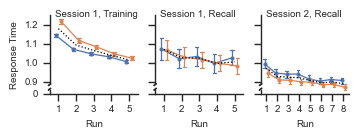

In [27]:
g = sns.catplot(x='run',
                y='response_time',
                hue='graph',
                col='session',
                kind="point",
                col_order=['one', 'check', 'two'],
                hue_order=['Modular', 'Lattice'],
#                 markers=['',''],
                capsize=.2,
                legend=False,
                dodge=0.3,
                sharex=False,
                # lw=0.1,
                height=1.5, aspect=.8,
                data=(sessions_all
                        .loc[lambda x: x.valid]
                        )
                )
g.map(sns.pointplot, 'run', 'response_time', color='black', errorbar=None, linestyles=':', markers=" ", 
      # order=['one', 'check', 'two'],
     )

# handles, labels = g.axes.flat[0].get_legend_handles_labels()
# handles.append(r.axes.flat[0].lines[-1])
# labels.append('Mean')
# plt.legend(handles=handles, labels=labels, title='Graph', loc='right')
g.axes.flat[0].text(-0.2, 1.24, 'Session 1, Training')
g.axes.flat[1].text(-0.2, 1.24, 'Session 1, Recall')
g.axes.flat[2].text(0, 1.24, 'Session 2, Recall')
g.set_titles('')
g.set(xlabel='Run')
g.set(ylabel='Response Time')
# Add axis cut
g.axes.flat[0].add_patch(Rectangle([-0.57, 0.86], 0.15, 0.02, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False))
g.axes.flat[0].add_patch(Rectangle([-0.57, 0.877], 0.14, 0.004, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=4))
g.axes.flat[0].add_patch(Rectangle([-0.57, 0.853], 0.14, 0.004, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=4))
g.axes.flat[1].add_patch(Rectangle([-0.57, 0.86], 0.15, 0.02, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False))
g.axes.flat[1].add_patch(Rectangle([-0.57, 0.877], 0.14, 0.004, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=4))
g.axes.flat[1].add_patch(Rectangle([-0.57, 0.853], 0.14, 0.004, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=4))
g.axes.flat[2].add_patch(Rectangle([-0.57, 0.86], 0.15, 0.02, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False))
g.axes.flat[2].add_patch(Rectangle([-0.62, 0.877], 0.24, 0.004, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=2.5))
g.axes.flat[2].add_patch(Rectangle([-0.62, 0.853], 0.24, 0.004, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=2.5))
# And set bottom axis to 0
yticks = g.axes.flat[0].get_yticks()
ylim = g.axes.flat[0].get_ylim()
yticks = [ylim[0], 0.9, 1, 1.1, 1.2]
yticklabels = [f'{x:0.1f}' for x in yticks]
yticklabels[0] = '0'
# yticklabels = []
# yticks[0] = ylim[0]
yticklabels = [f'{x:0.1f}' for x in yticks]
yticklabels[0] = '0'
g.set(yticks=yticks)
g.set(yticklabels=yticklabels)
# Save figure
g.savefig('images/behavior_response_time.pdf')

## Stats: Response time values

Reported response time values in the manuscript:
1. Separated by graph type
2. Combined for both graph types

In [28]:
sessions_all.loc[lambda x: x.valid].groupby(['session', 'graph', 'run'])['response_time'].mean().unstack()

run                     1         2         3         4         5         6  \
session graph                                                                 
check   Lattice  1.066407  1.029319  1.015494  0.995552  0.982547       NaN   
        Modular  1.072393  1.021000  1.031727  0.995944  1.024972       NaN   
one     Lattice  1.216605  1.116062  1.083084  1.046560  1.022954       NaN   
        Modular  1.143268  1.069855  1.045962  1.030415  1.004742       NaN   
two     Lattice  0.945121  0.909205  0.906327  0.899167  0.896245  0.884512   
        Modular  0.994438  0.944872  0.939234  0.939685  0.914384  0.902191   

run                     7         8  
session graph                        
check   Lattice       NaN       NaN  
        Modular       NaN       NaN  
one     Lattice       NaN       NaN  
        Modular       NaN       NaN  
two     Lattice  0.884752  0.869282  
        Modular  0.910810  0.905819

In [29]:
sessions_all.loc[lambda x: x.valid].loc[lambda x: x.session == 'one'].loc[lambda x: x.run == 1].loc[lambda x: x.graph == 'Modular'].groupby('subject')['response_time'].mean()

subject
GLS003    1.251401
GLS004    1.158778
GLS008    0.967547
GLS010    1.203245
GLS011    0.942973
GLS013    1.387192
GLS018    1.045283
GLS019    1.065421
GLS022    1.026961
GLS023    1.117745
GLS025    1.156808
GLS026    1.123892
GLS037    1.281180
GLS038    1.125265
GLS039    1.188817
GLS044    1.249041
Name: response_time, dtype: float64

In [30]:
sessions_all.loc[lambda x: x.valid].loc[lambda x: x.session == 'one'].loc[lambda x: x.run == 1].loc[lambda x: x.graph == 'Lattice'].groupby('subject')['response_time'].mean()

subject
GLS005    1.176922
GLS006    1.715807
GLS009    1.182368
GLS014    1.003401
GLS017    1.296729
GLS020    1.193309
GLS021    1.051919
GLS024    0.933230
GLS027    1.065678
GLS028    1.820765
GLS030    1.136891
GLS033    0.993413
GLS040    1.567027
GLS043    0.916288
GLS045    1.177519
Name: response_time, dtype: float64

In [31]:
sessions_all.loc[lambda x: x.valid].loc[lambda x: x.session == 'one'].groupby(['graph', 'run','subject'])['response_time'].mean().reset_index()

,graph,run,subject,response_time
0,Lattice,1,GLS005,1.176922
1,Lattice,1,GLS006,1.715807
2,Lattice,1,GLS009,1.182368
3,Lattice,1,GLS014,1.003401
4,Lattice,1,GLS017,1.296729
...,...,...,...,...
150,Modular,5,GLS026,0.868493
151,Modular,5,GLS037,1.161505
152,Modular,5,GLS038,1.040422
153,Modular,5,GLS039,1.429076


In [32]:
sessions_all.loc[lambda x: x.valid].groupby(['session', 'graph', 'run'])['response_time'].std().unstack()

run                     1         2         3         4         5         6  \
session graph                                                                 
check   Lattice  0.296502  0.315895  0.280687  0.280960  0.277199       NaN   
        Modular  0.274927  0.284357  0.296446  0.300183  0.286670       NaN   
one     Lattice  0.392413  0.375516  0.328551  0.316593  0.288476       NaN   
        Modular  0.257952  0.276785  0.275010  0.270736  0.278733       NaN   
two     Lattice  0.262695  0.249228  0.240730  0.239415  0.238471  0.230044   
        Modular  0.301567  0.284666  0.280207  0.266196  0.257798  0.248304   

run                     7         8  
session graph                        
check   Lattice       NaN       NaN  
        Modular       NaN       NaN  
one     Lattice       NaN       NaN  
        Modular       NaN       NaN  
two     Lattice  0.226451  0.221857  
        Modular  0.261931  0.242891

In [33]:
sessions_all.loc[lambda x: x.valid].groupby(['session', 'run'])['response_time'].mean().unstack()

run,1,2,3,4,5,6,7,8
session,,,,,,,,
check,1.068896,1.025332,1.023142,0.995745,1.004127,NaN,NaN,NaN
one,1.178375,1.092156,1.063530,1.038205,1.013476,NaN,NaN,NaN
two,0.970360,0.927557,0.923304,0.920035,0.905642,0.893654,0.89838,0.888164


## Figure 2b: Classification Accuracy by run

Figure 2b

/Users/arik/.pyenv/versions/miniconda3-latest/envs/jupyter/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


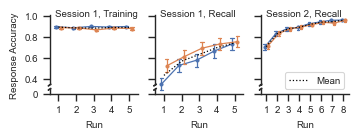

In [34]:
g = sns.catplot(x='run',
            y='correct',
            hue='graph',
            col='session',
            kind="point",
            col_order=['one', 'check', 'two'],
            hue_order=['Modular', 'Lattice'],
            capsize=.2,
            dodge=0.3,
            sharex=False,
            # linewidth=0.1,
            legend_out=False,
            height=1.5, aspect=.8,
            data=(sessions_all
                 )
            )
g.map(sns.pointplot, 'run', 'correct', color='black', errorbar=None, linestyles=':', markers="", label=None)
handles, labels = g.axes.flat[0].get_legend_handles_labels()
# labels[0] = 'Modular (n=16)'
# labels[1] = 'Lattice (n=15)'
handles.append(g.axes.flat[0].lines[-1])
labels.append('Mean')
plt.legend(handles=handles, labels=labels, 
#            title='Graph', 
           loc='lower right')
g.axes.flat[0].text(-0.2, 1, 'Session 1, Training')
g.axes.flat[1].text(-0.2, 1, 'Session 1, Recall')
g.axes.flat[2].text(0, 1, 'Session 2, Recall')
# g.set(ylim=(0.45, 1.05))
g.set_titles('')
g.set(xlabel='Run')
g.set(ylabel='Response Accuracy')
# Add axis cut
g.axes.flat[0].add_patch(Rectangle([-0.57, 0.31], 0.15, 0.03, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False))
g.axes.flat[0].add_patch(Rectangle([-0.58, 0.29], 0.16, 0.007, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=6))
g.axes.flat[0].add_patch(Rectangle([-0.58, 0.33], 0.16, 0.007, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=6))
g.axes.flat[1].add_patch(Rectangle([-0.57, 0.31], 0.15, 0.03, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False))
g.axes.flat[1].add_patch(Rectangle([-0.58, 0.29], 0.16, 0.007, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=6))
g.axes.flat[1].add_patch(Rectangle([-0.58, 0.33], 0.16, 0.007, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=6))
g.axes.flat[2].add_patch(Rectangle([-0.57, 0.31], 0.15, 0.025, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False))
g.axes.flat[2].add_patch(Rectangle([-0.62, 0.29], 0.24, 0.008, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=4))
g.axes.flat[2].add_patch(Rectangle([-0.62, 0.33], 0.24, 0.008, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=4))
# And set bottom axis to 0
yticks = g.axes.flat[0].get_yticks()[:-1]
ylim = g.axes.flat[0].get_ylim()[:-1]
yticks[0] = ylim[0]
yticklabels = [f'{x:0.1f}' for x in yticks]
yticklabels[0] = '0'
g.set(yticks=yticks)
g.set(yticklabels=yticklabels)
# Save figure
g.savefig('images/behavior_accuracy.pdf')

## Stats: Classification accuracy values

Reported accuracy values in the manuscript:
1. Separated by graph type
2. Combined for both graph types

In [35]:
sessions_all.groupby(['session', 'graph', 'run'])['correct'].mean().unstack()

run                     1         2         3         4         5        6  \
session graph                                                                
check   Lattice  0.524444  0.613333  0.693333  0.733333  0.755556      NaN   
        Modular  0.350000  0.529167  0.579167  0.666667  0.733333      NaN   
one     Lattice  0.889778  0.886000  0.868222  0.886000  0.881111      NaN   
        Modular  0.898750  0.888125  0.900833  0.895000  0.900208      NaN   
two     Lattice  0.714444  0.834444  0.878889  0.895556  0.917778  0.94000   
        Modular  0.702083  0.829167  0.878125  0.891667  0.925000  0.94375   

run                     7         8  
session graph                        
check   Lattice       NaN       NaN  
        Modular       NaN       NaN  
one     Lattice       NaN       NaN  
        Modular       NaN       NaN  
two     Lattice  0.933333  0.958889  
        Modular  0.959375  0.961458

In [36]:
sessions_all.groupby(['session', 'run'])['correct'].mean().unstack()

run,1,2,3,4,5,6,7,8
session,,,,,,,,
check,0.434409,0.569892,0.634409,0.698925,0.744086,NaN,NaN,NaN
one,0.894409,0.887097,0.885054,0.890645,0.890968,NaN,NaN,NaN
two,0.708065,0.831720,0.878495,0.893548,0.921505,0.941935,0.946774,0.960215


## RT trends

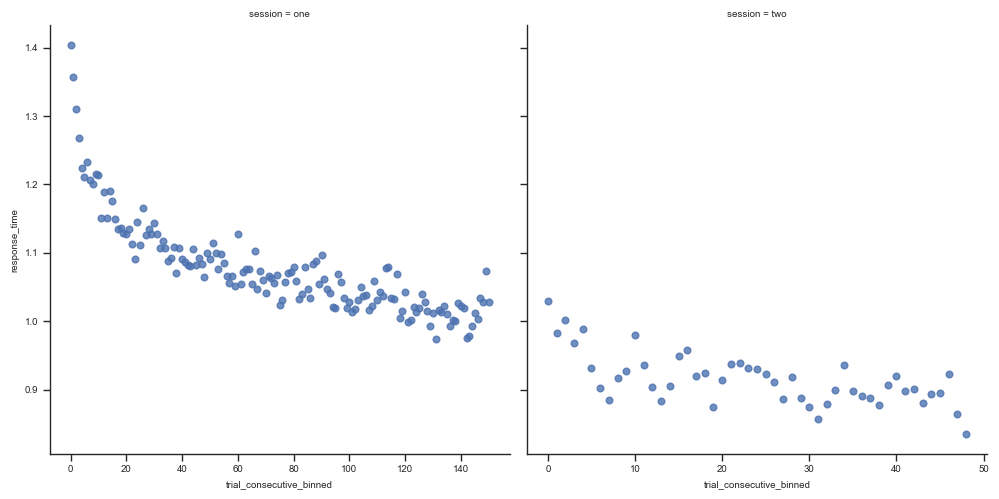

In [37]:
sns.lmplot(
    data=(sessions_all
          .loc[lambda x: x.valid]
          .assign(trial_consecutive_binned=lambda x: np.rint(x.trial_consecutive / 10))
          .groupby(['session', 'trial_consecutive_binned'])['response_time'].mean().reset_index()),
    x='trial_consecutive_binned', y='response_time', col='session', fit_reg=False, facet_kws={'sharex': False})

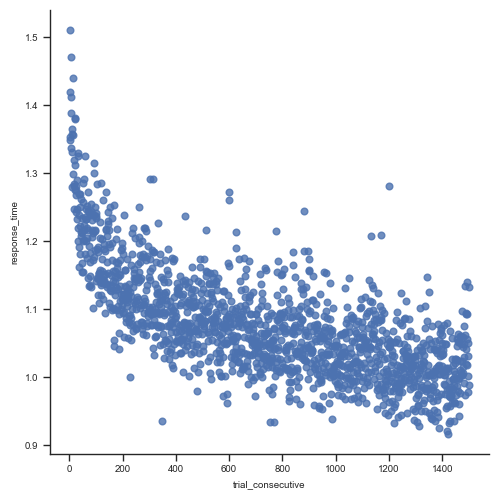

In [38]:
sns.lmplot(
    data=(session_one
          .loc[lambda x: x.valid]
          .assign(trial_consecutive_binned=lambda x: np.rint(x.trial_consecutive / 10))
          .groupby(['trial_consecutive'])['response_time'].mean().reset_index()),
    x='trial_consecutive', y='response_time', fit_reg=False, facet_kws={'sharex': False})

# Classification and Behavior

Derive our per-subject response time and accuracy measures

In [39]:
response_times = sessions_all.loc[lambda x: x.valid].groupby(['session', 'subject'])['response_time'].mean().reset_index()
accuracies = sessions_all.groupby(['session', 'subject'])['correct'].mean().rename('response_accuracy').reset_index()

Combine with classification accuracy results

In [40]:
classification_vs_response_accuracy = (
    results
    .loc[lambda x: ((x.voxels == '0') | 
                    ((x.roi != "loc-localized") & (x.voxels == "200")) | 
                    ((x.roi == "loc-localized") & (x.voxels == "600")))]
    .query(f'classifier == "{classifier}"')
    .query(f'rescale == {rescale}')
    .query(f'subtract_mean == {subtract_mean}')
    .groupby(['subject', 'roi', 'graph'])['correct_prediction']
    .mean()
    .dropna()
    .rename('classification_accuracy')
    .reset_index()
    .merge(accuracies, how='left')
)

In [41]:
classification_vs_response_time = (
    results
    .query('correct')
    .loc[lambda x: ((x.voxels == '0') | 
                    ((x.roi != "loc-localized") & (x.voxels == "200")) | 
                    ((x.roi == "loc-localized") & (x.voxels == "600")))]
    .query(f'classifier == "{classifier}"')
    .query(f'rescale == {rescale}')
    .query('correct == True')
    .query(f'subtract_mean == {subtract_mean}')
    .groupby(['subject', 'roi', 'graph'])['correct_prediction']
    .mean()
    .dropna()
    .rename('classification_accuracy')
    .reset_index()
    .merge(response_times, how='left')
)

In [42]:
classifier = 'node'
rescale=True
subtract_mean=True
acc_df = (results
          .loc[lambda x: (((x.voxels == "0"))
                          | ((x.roi != "loc-localized") & (x.voxels == "200"))
                          | ((x.roi == "loc-localized") & (x.voxels == "400")))]
          .query('correct == True')
          .query(f'classifier == "{classifier}"')
          .query(f'rescale == {rescale}')
          .query(f'subtract_mean == {subtract_mean}')
          .groupby(['subject', 'roi', 'graph'])['correct_prediction']
          .mean()
          .dropna()
          .rename('Classification Accuracy')
          .reset_index()
         )
plot_rc = {'font.family': ['sans-serif'],
           'font.sans-serif': ['Arial'],
           'font.size': 7,
           'axes.titlesize': 7,
           'axes.labelsize': 7,
           'xtick.labelsize': 7,
           'ytick.labelsize': 7,
           'legend.fontsize': 7,
           'legend.title_fontsize': 7}

# Postcentral Gyrus: Classification and Behavior

In [43]:
postcentral_classification_min = (acc_df
 .loc[lambda x: (x.roi == 'postcentral-both')]
).min()['Classification Accuracy']

postcentral_classification_max = (acc_df
 .loc[lambda x: (x.roi == 'postcentral-both')]
).max()['Classification Accuracy']

print(f'Minimum classification accuracy: {postcentral_classification_min:0.3f}')
print(f'Maximum classification accuracy: {postcentral_classification_max:0.3f}')

Minimum classification accuracy: 0.059
Maximum classification accuracy: 0.170


## Figure 3a: Postcentral Gyrus boxplots

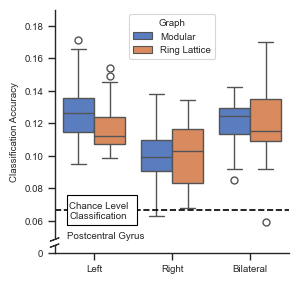

In [44]:
sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc=plot_rc)
g = sns.catplot(data=(acc_df
                      .loc[lambda x: (x.roi == 'postcentral-lh') | (x.roi == 'postcentral-rh') | (x.roi == 'postcentral-both')]
                      .replace({'Lattice': 'Ring Lattice'})
                      .replace({'postcentral-lh': 'Left',
                                'postcentral-rh': 'Right',
                                'postcentral-both': 'Bilateral'})
                      .rename(columns={'graph': 'Graph'})
                     ),
                x='roi',
                y='Classification Accuracy',
                hue='Graph',
                order=['Left', 'Right', 'Bilateral'],
                height=3,
                legend_out=False,
                palette='muted',
                kind='box')
# Basic Formatting
g.set(xlabel=None)
g.set(title=None)
g.set(ylim=(0.04, 0.19))

# Add chance line
transAxes = g.axes.flat[0].transAxes
baseline = 1/15.0
baseline_axis = g.axes.flat[0].transLimits.transform((0, baseline))[1]  # Get baseline in axis coordinates
chance_box_height = 0.12
chance_box_width = 0.3
chance_text_center = baseline_axis - 0.035  # vertical center of chance text
roi_text_center = baseline_axis - 0.115  # vertical center of roi label
text_xloc = 0.05  # X location of ROI and chance text box, in axis coordinates
g.axes.flat[0].axhline(y=baseline, linestyle='--', color='black', label='Chance')
g.axes.flat[0].text(text_xloc, roi_text_center, 'Postcentral Gyrus', transform=transAxes)
g.axes.flat[0].add_patch(Rectangle([text_xloc, baseline_axis - chance_box_height/2], chance_box_width, chance_box_height, transform=transAxes, edgecolor='Black', alpha=1, facecolor="white", zorder=100))
g.axes.flat[0].text(text_xloc + 0.01, chance_text_center, 'Chance Level\nClassification', zorder=101, transform=transAxes)

# Add axis cut
g.axes.flat[0].add_patch(Rectangle([-0.005, 0.035], 0.01, 0.02, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.025], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.05], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))

# And set bottom axis to 0
yticks = g.axes.flat[0].get_yticks()
yticks = np.concatenate(([g.axes.flat[0].get_ylim()[0]], yticks[1:-1]))
yticklabels = [f'{x:0.2f}' for x in yticks]
yticklabels[0] = '0'
g.set(yticks=yticks)
g.set(yticklabels=yticklabels)

# Save
g.savefig('images/classification_postcentral_rois_boxplot.pdf')

## Stats: Hemispheric classification diferences

Is the difference between left and right hemispheres significant?

Two-sided paired t-test

In [45]:
from scipy.stats import ttest_rel
x1 = (acc_df
                      .loc[lambda x: (x.roi == 'postcentral-lh')]
                     )['Classification Accuracy'].values
x2 = (acc_df
                      .loc[lambda x: (x.roi == 'postcentral-rh')]
                     )['Classification Accuracy'].values
print('Postcentral, Left vs. Right Classification Accuracy')
ttest_rel(x1, x2)

Postcentral, Left vs. Right Classification Accuracy


TtestResult(statistic=6.551950208890071, pvalue=3.014350587580961e-07, df=30)

What about between left and bilateral?

In [46]:
from scipy.stats import ttest_rel
x1 = (acc_df
                      .loc[lambda x: (x.roi == 'postcentral-both')]
                     )['Classification Accuracy'].values
x2 = (acc_df
                      .loc[lambda x: (x.roi == 'postcentral-lh')]
                     )['Classification Accuracy'].values
print('Postcentral, Bilateral vs. Left Classification Accuracy')
print(ttest_rel(x1, x2))

Postcentral, Bilateral vs. Left Classification Accuracy
TtestResult(statistic=-0.6374418700626101, pvalue=0.5286723974012844, df=30)


## Figure 3b: Postcentral Gyrus classification vs. response time

/Users/arik/.pyenv/versions/miniconda3-latest/envs/jupyter/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


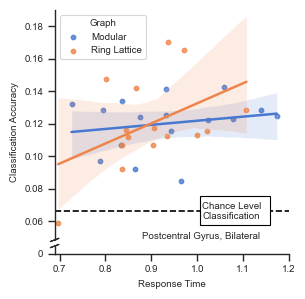

In [47]:
# sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc=plot_rc)

g = sns.lmplot(data=(classification_vs_response_time
                     .loc[lambda x: x.session == 'two']
                     .loc[lambda x: x.roi == 'postcentral-both']
                     .replace({'Lattice': 'Ring Lattice'})
                     .rename(columns={'graph': 'Graph'})
                    ),
               x='response_time',
               y='classification_accuracy',
               hue='Graph',
               height=3, # Gives width of 3in
               scatter_kws={"s": 10},
               legend_out=False,
               palette='muted',
               fit_reg=True)
# Basic Formatting
g.set(xlabel='Response Time')
g.set(ylabel='Classification Accuracy')
g.set(title=None)
g.set(xlim=(0.69, 1.2))
g.set(ylim=(0.04, 0.19))
plt.legend(loc='upper left', title='Graph')

# Add chance line
transAxes = g.axes.flat[0].transAxes
baseline_axis = g.axes.flat[0].transLimits.transform((0, baseline))[1]  # Get baseline in axis coordinates
baseline = 1/15.0
chance_box_height = 0.12
chance_box_width = 0.3
chance_text_center = baseline_axis - 0.035  # vertical center of chance text
roi_text_center = baseline_axis - 0.115  # vertical center of roi label
text_xloc = 0.62  # X location of ROI and chance text box, in axis coordinates
g.axes.flat[0].axhline(y=baseline, linestyle='--', color='black', label='Chance')
g.axes.flat[0].text(text_xloc - 0.25, roi_text_center, 'Postcentral Gyrus, Bilateral', transform=transAxes)
g.axes.flat[0].add_patch(Rectangle([text_xloc, baseline_axis - chance_box_height/2], chance_box_width, chance_box_height, transform=transAxes, edgecolor='Black', alpha=1, facecolor="white", zorder=100))
g.axes.flat[0].text(text_xloc + 0.01, chance_text_center, 'Chance Level\nClassification', zorder=101, transform=transAxes)

# Add axis cut
g.axes.flat[0].add_patch(Rectangle([-0.005, 0.035], 0.01, 0.02, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.025], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.05], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))

# And set bottom axis to 0
yticks = g.axes.flat[0].get_yticks()
yticks = np.concatenate(([g.axes.flat[0].get_ylim()[0]], yticks[1:-1]))
yticklabels = [f'{x:0.2f}' for x in yticks]
yticklabels[0] = '0'
g.set(yticks=yticks)
g.set(yticklabels=yticklabels)
# Save
g.savefig('images/classification_vs_response_time_session_two_postcentral_combined.pdf')

## Stats: Postcentral gyrus classification accuracy vs. response time

In [48]:
classification_vs_response_time['zscore_response_time'] = ((classification_vs_response_time['response_time'] -
                                                            classification_vs_response_time['response_time'].mean()) /
                                                           classification_vs_response_time['response_time'].std())

roi = 'postcentral-both'
mod = smf.ols(formula='classification_accuracy ~ zscore_response_time * graph',
              data=(classification_vs_response_time
                 .loc[lambda x: x.session == 'two']
                 .loc[lambda x: x.roi == roi]
                )
             )
res = mod.fit()
print(res.summary())

                               OLS Regression Results                              
Dep. Variable:     classification_accuracy   R-squared:                       0.153
Model:                                 OLS   Adj. R-squared:                  0.059
Method:                      Least Squares   F-statistic:                     1.627
Date:                     Mon, 12 Feb 2024   Prob (F-statistic):              0.206
Time:                             10:28:33   Log-Likelihood:                 76.776
No. Observations:                       31   AIC:                            -145.6
Df Residuals:                           27   BIC:                            -139.8
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

## Stats: Postcentral gyrus classification accuracy vs. response accuracy

In [49]:
roi = 'postcentral-both'
mod = smf.ols(formula='classification_accuracy ~ response_accuracy * graph',
              data=(classification_vs_response_accuracy
                 .loc[lambda x: x.session == 'two']
                 .loc[lambda x: x.roi == roi]
                )
             )
res = mod.fit()
print(res.summary())

                               OLS Regression Results                              
Dep. Variable:     classification_accuracy   R-squared:                       0.020
Model:                                 OLS   Adj. R-squared:                 -0.089
Method:                      Least Squares   F-statistic:                    0.1803
Date:                     Mon, 12 Feb 2024   Prob (F-statistic):              0.909
Time:                             10:28:33   Log-Likelihood:                 75.365
No. Observations:                       31   AIC:                            -142.7
Df Residuals:                           27   BIC:                            -137.0
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

# LOC: Classification and Behavior

In [50]:
loc_classification_min = (acc_df
 .loc[lambda x: (x.roi == 'loc-localized')]
).min()['Classification Accuracy']

loc_classification_max = (acc_df
 .loc[lambda x: (x.roi == 'loc-localized')]
).max()['Classification Accuracy']

print(f'Minimum classification accuracy: {loc_classification_min:0.3f}')
print(f'Maximum classification accuracy: {loc_classification_max:0.3f}')

Minimum classification accuracy: 0.156
Maximum classification accuracy: 0.409


## Figure 4a: LOC boxplots

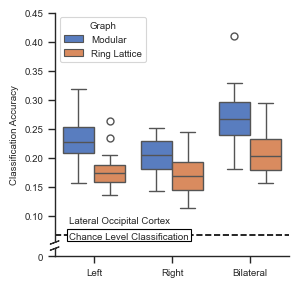

In [51]:
sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc=plot_rc)
g = sns.catplot(data=(acc_df
                      .loc[lambda x: (x.roi == 'loc-localized-lh') | (x.roi == 'loc-localized-rh') | (x.roi == 'loc-localized')]
                      .replace({'Lattice': 'Ring Lattice'})
                      .replace({'loc-localized-lh': 'Left',
                                'loc-localized-rh': 'Right',
                                'loc-localized': 'Bilateral'})
                      .rename(columns={'graph': 'Graph'})
                     ),
                x='roi',
                y='Classification Accuracy',
                hue='Graph',
                order=['Left', 'Right', 'Bilateral'],
                height=3,
                legend_out=False,
                palette='muted',
                kind='box')
# Basic Formatting
g.set(xlabel=None)
g.set(ylim=(0.03, 0.45))
g.set(title=None)
# Add chance line
transAxes = g.axes.flat[0].transAxes
baseline = 1/15.0
chance_box_height = 0.05
text_xloc = 0.06
# Get baseline in axis coordinates
baseline_axis = g.axes.flat[0].transLimits.transform((0, baseline))[1]
g.axes.flat[0].axhline(y=baseline, linestyle='--', color='black', label='Chance')
g.axes.flat[0].text(text_xloc, baseline_axis + 0.05, 'Lateral Occipital Cortex', transform=transAxes)
g.axes.flat[0].add_patch(Rectangle([text_xloc - 0.01, baseline_axis - chance_box_height/2], 0.533, chance_box_height, transform=transAxes, edgecolor='Black', alpha=1, facecolor="white", zorder=100))
g.axes.flat[0].text(text_xloc, baseline_axis - 0.015, 'Chance Level Classification', zorder=101, transform=transAxes)
# g.axes.flat[0].axhline(y=baseline, linestyle='--', color='black', label='Chance')
# g.axes.flat[0].text(0.13, baseline - 0.0005, 'Chance Level Classification', zorder=101, ha='center')
# g.axes.flat[0].add_patch(Rectangle([-0.45, baseline-0.005], 1.16, 0.0155, edgecolor='Black', alpha=1, facecolor="white", zorder=100))
# Add axis cut
g.axes.flat[0].add_patch(Rectangle([-0.005, 0.035], 0.01, 0.02, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.025], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.05], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
# And set bottom axis to 0
yticks = g.axes.flat[0].get_yticks()
yticks = np.concatenate(([0.03], yticks[2:]))
yticklabels = [f'{x:0.2f}' for x in yticks]
yticklabels[0] = '0'
g.set(yticks=yticks)
g.set(yticklabels=yticklabels)
# Save
g.savefig('images/classification_loc_localized_rois_boxplot.pdf')

## Figure 4b: LOC classification vs. response time

/Users/arik/.pyenv/versions/miniconda3-latest/envs/jupyter/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


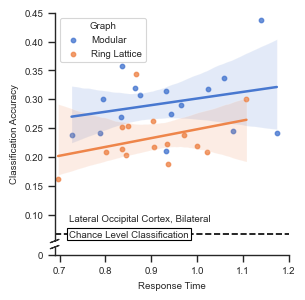

In [52]:
# sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc=plot_rc)

g = sns.lmplot(data=(classification_vs_response_time
                     .loc[lambda x: x.session == 'two']
                     .loc[lambda x: x.roi == 'loc-localized']
                     .rename(columns={'graph': 'Graph'})
                     .replace({'Lattice': 'Ring Lattice'})
                    ),
               x='response_time',
               y='classification_accuracy',
               hue='Graph',
               height=3, # Gives width of 3in
               scatter_kws={"s": 10},
               legend_out=False,
               palette='muted',
               fit_reg=True)
# Basic Formatting
g.set(xlim=(0.69, 1.2))
g.set(xlabel='Response Time')
g.set(ylabel='Classification Accuracy')
g.set(title=None)
g.set(ylim=(0.03, 0.45))
# Add chance line
transAxes = g.axes.flat[0].transAxes
baseline = 1/15.0
chance_box_height = 0.05
text_xloc = 0.06
# Get baseline in axis coordinates
baseline_axis = g.axes.flat[0].transLimits.transform((0, baseline))[1]
g.axes.flat[0].axhline(y=baseline, linestyle='--', color='black', label='Chance')
g.axes.flat[0].text(text_xloc, baseline_axis + 0.05, 'Lateral Occipital Cortex, Bilateral', transform=transAxes)
g.axes.flat[0].add_patch(Rectangle([text_xloc - 0.01, baseline_axis - chance_box_height/2], 0.533, chance_box_height, transform=transAxes, edgecolor='Black', alpha=1, facecolor="white", zorder=100))
g.axes.flat[0].text(text_xloc, baseline_axis - 0.015, 'Chance Level Classification', zorder=101, transform=transAxes)
# Add axis cut
g.axes.flat[0].add_patch(Rectangle([-0.005, 0.035], 0.01, 0.02, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.025], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.05], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
# And set bottom axis to 0
yticks = g.axes.flat[0].get_yticks()
yticks = np.concatenate(([0.03], yticks[2:]))
yticklabels = [f'{x:0.2f}' for x in yticks]
yticklabels[0] = '0'
g.set(yticks=yticks)
g.set(yticklabels=yticklabels)
# Save
g.savefig('images/classification_vs_response_time_session_two_loc_both.pdf')

## Stats: LOC classification accuracy vs. response time

In [53]:
classification_vs_response_time['zscore_response_time'] = ((classification_vs_response_time['response_time'] -
                                                            classification_vs_response_time['response_time'].mean()) /
                                                           classification_vs_response_time['response_time'].std())

roi = 'loc-localized'
mod = smf.ols(formula='classification_accuracy ~ zscore_response_time * graph',
              data=(classification_vs_response_time
                 .loc[lambda x: x.session == 'two']
                 .loc[lambda x: x.roi == roi]
                )
             )
res = mod.fit()
print(res.summary())

                               OLS Regression Results                              
Dep. Variable:     classification_accuracy   R-squared:                       0.338
Model:                                 OLS   Adj. R-squared:                  0.265
Method:                      Least Squares   F-statistic:                     4.603
Date:                     Mon, 12 Feb 2024   Prob (F-statistic):            0.00998
Time:                             10:28:33   Log-Likelihood:                 50.542
No. Observations:                       31   AIC:                            -93.08
Df Residuals:                           27   BIC:                            -87.35
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

## Stats: LOC classification accuracy vs. response accuracy

In [54]:
roi = 'loc-localized'
mod = smf.ols(formula='classification_accuracy ~ response_accuracy * graph',
              data=(classification_vs_response_accuracy
                 .loc[lambda x: x.session == 'two']
                 .loc[lambda x: x.roi == roi]
                )
             )
res = mod.fit()
print(res.summary())

                               OLS Regression Results                              
Dep. Variable:     classification_accuracy   R-squared:                       0.296
Model:                                 OLS   Adj. R-squared:                  0.218
Method:                      Least Squares   F-statistic:                     3.789
Date:                     Mon, 12 Feb 2024   Prob (F-statistic):             0.0217
Time:                             10:28:33   Log-Likelihood:                 51.021
No. Observations:                       31   AIC:                            -94.04
Df Residuals:                           27   BIC:                            -88.31
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

## ANOVA: Classification Accuracy differs between graphs

Do we observe higher classification accuracy in participants trained on the modular graph than in participants trained on the lattice graph?

We're looking at both ROI and Graph as factors

Note this section is being run in R. It may be easier to separately export the CSV and then run the analysis in RStudio, etc, but here I'm using rpy2 to directly interface between R and python

In [55]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

robjects.r("""
get_confint <- function(model) {
  return(get_confint_summary(summary(model)))
}

get_confint_summary <- function(summary) {
  coefficients <- summary$coefficients
  
  lb <- coefficients[,c("Estimate")] - 1.96*coefficients[,c("Std. Error")]
  ub <- coefficients[,c("Estimate")] + 1.96*coefficients[,c("Std. Error")]
  
  coef.start <- coefficients[,1:2]
  coef.end <- coefficients[,3:dim(coefficients)[[2]]]
  
  coef.start <- cbind(coef.start, lb)
  colnames(coef.start)[[length(colnames(coef.start))]] <- "95% Conf. Int."
  
  coef.start <- cbind(coef.start, ub) 
  colnames(coef.start)[[length(colnames(coef.start))]] <- ""
  
  coef.start <- cbind(coef.start, coef.end)
  
  
  coef.start <- as_tibble(coef.start, rownames="Variable")
  
  coef.start <-
    coef.start %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.1, ".", "")) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.05, "*", Sig.)) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.01, "**", Sig.)) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.001, "***", Sig.))
  
  colnames(coef.start)[[1]] <- " "
  colnames(coef.start)[[5]] <- " "
  
  return(coef.start)
}
""")

df = classification_vs_response_time.loc[lambda x: (x.roi.isin(['postcentral-rh', 'postcentral-lh', 'postcentral-both'])) & (x.session == 'two')]
df.to_csv('data/classification_vs_response_time_postcentral.csv', index=False)
df = classification_vs_response_time.loc[lambda x: (x.roi.isin(['loc-localized-rh', 'loc-localized-lh', 'loc-localized'])) & (x.session == 'two')]
df.to_csv('data/classification_vs_response_time_loc-localized.csv', index=False)

rstring="""
    cluster_test <- function(){
        library(xtable)
        library(readr)
        library(tibble)
        library(dplyr)
        library(rstatix)
        data <- read_csv('data/classification_vs_response_time_postcentral.csv', col_types='fffdfddd')
        # Two-way mixed ANOVA test
        res.aov <- anova_test(
          data = data, dv = classification_accuracy, wid = subject,
          between = graph, within = roi
          )
        print('Postcentral')
        print(get_anova_table(res.aov))
        data <- read_csv('data/classification_vs_response_time_loc-localized.csv', col_types='fffdfddd')
        # Two-way mixed ANOVA test
        res.aov  <- anova_test(
          data = data, dv = classification_accuracy, wid = subject,
          between = graph, within = roi
          )
        print('LOC')
        print(get_anova_table(res.aov))
    }
"""
rfunc=robjects.r(rstring)

# rdata=ts(traindf.Price.values,frequency=4)
r_df=rfunc()

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘rstatix’


R[write to console]: The following object is masked from ‘package:stats’:

    filter




[1] "Postcentral"
ANOVA Table (type III tests)

     Effect DFn DFd      F        p p<.05   ges
1     graph   1  29  0.160 6.92e-01       0.004
2       roi   2  58 21.741 9.00e-08     * 0.202
3 graph:roi   2  58  0.952 3.92e-01       0.011
[1] "LOC"
ANOVA Table (type III tests)

     Effect DFn DFd      F        p p<.05   ges
1     graph   1  29 14.140 7.64e-04     * 0.266
2       roi   2  58 73.267 1.34e-16     * 0.392
3 graph:roi   2  58  1.786 1.77e-01       0.015


# Hippocampus

In [56]:
hippocampus_classification_min = (acc_df
 .loc[lambda x: (x.roi == 'hippocampus-both')]
).min()['Classification Accuracy']

hippocampus_classification_max = (acc_df
 .loc[lambda x: (x.roi == 'hippocampus-both')]
).max()['Classification Accuracy']

print(f'Minimum classification accuracy: {hippocampus_classification_min:0.3f}')
print(f'Maximum classification accuracy: {hippocampus_classification_max:0.3f}')

Minimum classification accuracy: 0.036
Maximum classification accuracy: 0.096


In [57]:
ttest_1samp(acc_df[(acc_df.roi == "hippocampus-lh") & (acc_df.graph == "Lattice")]["Classification Accuracy"], 1/15.0)

TtestResult(statistic=2.219822062695115, pvalue=0.04345340315846933, df=14)

T-test, loc-localized Modular
TtestResult(statistic=0.35851767969994885, pvalue=0.7249517541004203, df=15)
T-test, loc-localized Lattice
TtestResult(statistic=2.219822062695115, pvalue=0.04345340315846933, df=14)
TtestResult(statistic=1.5125891314343654, pvalue=0.14120653836784477, df=29.0)


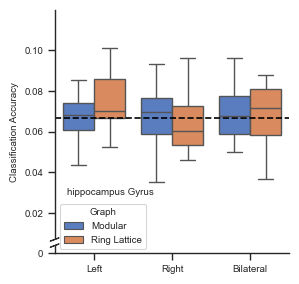

In [58]:
sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc=plot_rc)
g = sns.catplot(data=(acc_df
                      .loc[lambda x: (x.roi == 'hippocampus-lh') | (x.roi == 'hippocampus-rh') | (x.roi == 'hippocampus-both')]
                      .replace({'Lattice': 'Ring Lattice'})
                      .replace({'hippocampus-lh': 'Left',
                                'hippocampus-rh': 'Right',
                                'hippocampus-both': 'Bilateral'})
                      .rename(columns={'graph': 'Graph'})
                     ),
                x='roi',
                y='Classification Accuracy',
                hue='Graph',
                order=['Left', 'Right', 'Bilateral'],
                height=3,
                legend_out=False,
                palette='muted',
                kind='box')
# Basic Formatting
g.set(xlabel=None)
g.set(title=None)
g.set(ylim=(0.00, 0.12))

# Add chance line
transAxes = g.axes.flat[0].transAxes
baseline = 1/15.0
baseline_axis = g.axes.flat[0].transLimits.transform((0, baseline))[1]  # Get baseline in axis coordinates
chance_box_height = 0.12
chance_box_width = 0.3
chance_text_center = baseline_axis - 0.035  # vertical center of chance text
roi_text_center = baseline_axis - 0.315  # vertical center of roi label
text_xloc = 0.05  # X location of ROI and chance text box, in axis coordinates
g.axes.flat[0].axhline(y=baseline, linestyle='--', color='black', label='Chance')
g.axes.flat[0].text(text_xloc, roi_text_center, 'hippocampus Gyrus', transform=transAxes)
# g.axes.flat[0].add_patch(Rectangle([text_xloc, baseline_axis - chance_box_height/2], chance_box_width, chance_box_height, transform=transAxes, edgecolor='Black', alpha=1, facecolor="white", zorder=100))
# g.axes.flat[0].text(text_xloc + 0.01, chance_text_center, 'Chance Level\nClassification', zorder=101, transform=transAxes)

# Add axis cut
g.axes.flat[0].add_patch(Rectangle([-0.005, 0.035], 0.01, 0.02, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.025], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.05], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))

# And set bottom axis to 0
yticks = g.axes.flat[0].get_yticks()
yticks = np.concatenate(([g.axes.flat[0].get_ylim()[0]], yticks[1:-1]))
yticklabels = [f'{x:0.2f}' for x in yticks]
yticklabels[0] = '0'
g.set(yticks=yticks)
g.set(yticklabels=yticklabels)

# Save
g.savefig('images/classification_hippocampus_rois_boxplot.pdf')

print("T-test, loc-localized Modular")
print(ttest_1samp(acc_df[(acc_df.roi == "hippocampus-lh") & (acc_df.graph == "Modular")]["Classification Accuracy"], 1/15.0))
print("T-test, loc-localized Lattice")
print(ttest_1samp(acc_df[(acc_df.roi == "hippocampus-lh") & (acc_df.graph == "Lattice")]["Classification Accuracy"], 1/15.0))

print(ttest_ind(acc_df[(acc_df.roi == "hippocampus-lh") & (acc_df.graph == "Lattice")]["Classification Accuracy"], acc_df[(acc_df.roi == "hippocampus-lh") & (acc_df.graph == "Modular")]["Classification Accuracy"]))

g

In [59]:
print("T-test, loc-localized Modular")
print(ttest_1samp(acc_df[(acc_df.roi == "hippocampus-lh") & (acc_df.graph == "Modular")]["Classification Accuracy"], 1/15.0))
print("T-test, loc-localized Lattice")
print(ttest_1samp(acc_df[(acc_df.roi == "hippocampus-lh") & (acc_df.graph == "Lattice")]["Classification Accuracy"], 1/15.0))

print(ttest_ind(acc_df[(acc_df.roi == "hippocampus-lh") & (acc_df.graph == "Lattice")]["Classification Accuracy"], acc_df[(acc_df.roi == "hippocampus-lh") & (acc_df.graph == "Modular")]["Classification Accuracy"]))

T-test, loc-localized Modular
TtestResult(statistic=0.35851767969994885, pvalue=0.7249517541004203, df=15)
T-test, loc-localized Lattice
TtestResult(statistic=2.219822062695115, pvalue=0.04345340315846933, df=14)
TtestResult(statistic=1.5125891314343654, pvalue=0.14120653836784477, df=29.0)


In [60]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

robjects.r("""
get_confint <- function(model) {
  return(get_confint_summary(summary(model)))
}

get_confint_summary <- function(summary) {
  coefficients <- summary$coefficients
  
  lb <- coefficients[,c("Estimate")] - 1.96*coefficients[,c("Std. Error")]
  ub <- coefficients[,c("Estimate")] + 1.96*coefficients[,c("Std. Error")]
  
  coef.start <- coefficients[,1:2]
  coef.end <- coefficients[,3:dim(coefficients)[[2]]]
  
  coef.start <- cbind(coef.start, lb)
  colnames(coef.start)[[length(colnames(coef.start))]] <- "95% Conf. Int."
  
  coef.start <- cbind(coef.start, ub) 
  colnames(coef.start)[[length(colnames(coef.start))]] <- ""
  
  coef.start <- cbind(coef.start, coef.end)
  
  
  coef.start <- as_tibble(coef.start, rownames="Variable")
  
  coef.start <-
    coef.start %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.1, ".", "")) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.05, "*", Sig.)) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.01, "**", Sig.)) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.001, "***", Sig.))
  
  colnames(coef.start)[[1]] <- " "
  colnames(coef.start)[[5]] <- " "
  
  return(coef.start)
}
""")

df = classification_vs_response_time.loc[lambda x: (x.roi.isin(['hippocampus-rh', 'hippocampus-lh', 'hippocampus-both'])) & (x.session == 'two')]
df.to_csv('data/classification_vs_response_time_hippocampus.csv', index=False)

rstring="""
    cluster_test <- function(){
        library(xtable)
        library(readr)
        library(tibble)
        library(dplyr)
        library(rstatix)
        data <- read_csv('data/classification_vs_response_time_hippocampus.csv', col_types='fffdfddd')
        # Two-way mixed ANOVA test
        res.aov <- anova_test(
          data = data, dv = classification_accuracy, wid = subject,
          between = graph, within = roi
          )
        print('Hippocampus')
        print(get_anova_table(res.aov))
    }
"""
rfunc=robjects.r(rstring)

# rdata=ts(traindf.Price.values,frequency=4)
r_df=rfunc()

[1] "Hippocampus"
ANOVA Table (type III tests)

     Effect DFn DFd     F     p p<.05   ges
1     graph   1  29 0.213 0.648       0.003
2       roi   2  58 1.417 0.251       0.030
3 graph:roi   2  58 1.027 0.365       0.022


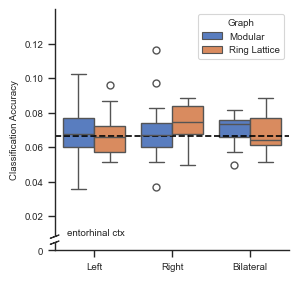

In [61]:
sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc=plot_rc)
g = sns.catplot(data=(acc_df
                      .loc[lambda x: (x.roi == 'entorhinal-lh') | (x.roi == 'entorhinal-rh') | (x.roi == 'entorhinal-both')]
                      .replace({'Lattice': 'Ring Lattice'})
                      .replace({'entorhinal-lh': 'Left',
                                'entorhinal-rh': 'Right',
                                'entorhinal-both': 'Bilateral'})
                      .rename(columns={'graph': 'Graph'})
                     ),
                x='roi',
                y='Classification Accuracy',
                hue='Graph',
                order=['Left', 'Right', 'Bilateral'],
                height=3,
                legend_out=False,
                palette='muted',
                kind='box')
# Basic Formatting
g.set(xlabel=None)
g.set(title=None)
g.set(ylim=(0.00, 0.14))

# Add chance line
transAxes = g.axes.flat[0].transAxes
baseline = 1/15.0
baseline_axis = g.axes.flat[0].transLimits.transform((0, baseline))[1]  # Get baseline in axis coordinates
chance_box_height = 0.12
chance_box_width = 0.3
chance_text_center = baseline_axis - 0.035  # vertical center of chance text
roi_text_center = baseline_axis - 0.415  # vertical center of roi label
text_xloc = 0.05  # X location of ROI and chance text box, in axis coordinates
g.axes.flat[0].axhline(y=baseline, linestyle='--', color='black', label='Chance')
g.axes.flat[0].text(text_xloc, roi_text_center, 'entorhinal ctx', transform=transAxes)
# g.axes.flat[0].add_patch(Rectangle([text_xloc, baseline_axis - chance_box_height/2], chance_box_width, chance_box_height, transform=transAxes, edgecolor='Black', alpha=1, facecolor="white", zorder=100))
# g.axes.flat[0].text(text_xloc + 0.01, chance_text_center, 'Chance Level\nClassification', zorder=101, transform=transAxes)

# Add axis cut
g.axes.flat[0].add_patch(Rectangle([-0.005, 0.035], 0.01, 0.02, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.025], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.05], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))

# And set bottom axis to 0
yticks = g.axes.flat[0].get_yticks()
yticks = np.concatenate(([g.axes.flat[0].get_ylim()[0]], yticks[1:-1]))
yticklabels = [f'{x:0.2f}' for x in yticks]
yticklabels[0] = '0'
g.set(yticks=yticks)
g.set(yticklabels=yticklabels)

# Save
g.savefig('images/classification_entorhinal_rois_boxplot.pdf')

# Surprisal Effect (Supplement)

In [80]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

df = session_one[session_one.valid 
                 & (session_one.trial_consecutive > 30) 
                 & (session_one.graph == 'Modular')
                ].copy()
df['z_trial_consecutive'] = (df['trial_consecutive'] - df['trial_consecutive'].mean()) / (df['trial_consecutive'].std())
df['log_trial_consecutive'] = np.log(df['trial_consecutive'] + 1)
df['z_log_trial_consecutive'] = (df['log_trial_consecutive'] - df['log_trial_consecutive'].mean()) / (2 * df['log_trial_consecutive'].std())
df['is_lattice'] = df['graph'] == 'Lattice'
df['trial'] = df['z_log_trial_consecutive']
df['shape'] = df['shape'].astype(int)
df[['subject', 'movement', 'shape', 'cross_cluster', 'trial', 'response_time', 'is_lattice']].to_csv('data/session_one.csv', index=False)

robjects.r("""
get_confint <- function(model) {
  return(get_confint_summary(summary(model)))
}

get_confint_summary <- function(summary) {
  coefficients <- summary$coefficients
  
  lb <- coefficients[,c("Estimate")] - 1.96*coefficients[,c("Std. Error")]
  ub <- coefficients[,c("Estimate")] + 1.96*coefficients[,c("Std. Error")]
  
  coef.start <- coefficients[,1:2]
  coef.end <- coefficients[,3:dim(coefficients)[[2]]]
  
  coef.start <- cbind(coef.start, lb)
  colnames(coef.start)[[length(colnames(coef.start))]] <- "95% Conf. Int."
  
  coef.start <- cbind(coef.start, ub) 
  colnames(coef.start)[[length(colnames(coef.start))]] <- ""
  
  coef.start <- cbind(coef.start, coef.end)
  
  
  coef.start <- as_tibble(coef.start, rownames="Variable")
  
  coef.start <-
    coef.start %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.1, ".", "")) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.05, "*", Sig.)) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.01, "**", Sig.)) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.001, "***", Sig.))
  
  colnames(coef.start)[[1]] <- " "
  colnames(coef.start)[[5]] <- " "
  
  return(coef.start)
}
""")

rstring="""
    cluster_test <- function(){
        library(lmerTest)
        library(xtable)
        library(readr)
        library(tibble)
        library(dplyr)
        data <- read_csv('data/session_one.csv', col_types='ffflddl')
        data$shape <- factor(data$shape, levels=c("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15"))
        data$movement <- factor(data$movement, levels=c("[10000]", "[01000]", "[00100]", "[00010]", "[00001]", "[11000]", "[01100]", "[00110]", "[00011]", "[10100]", "[01010]", "[00101]", "[10010]", "[01001]", "[10001]"))
        result <- lmer('response_time ~ trial * cross_cluster + movement + shape + (1 + trial + cross_cluster | subject)', data=data, REML=TRUE)
        print(summary(result))
        print(xtable(get_confint(result), 
             digits=c(2,2,3,3,3,3,0,2,2,2), 
             display=c("s","f","f","f","f","f","f","f","g","s")),
      include.rownames=FALSE)
    }
"""
rfunc=robjects.r(rstring)

# rdata=ts(traindf.Price.values,frequency=4)
r_df=rfunc()

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
"response_time ~ trial * cross_cluster + movement + shape + (1 + trial + cross_cluster | subject)"
   Data: data

REML criterion at convergence: -8321.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.8943 -0.5995 -0.0922  0.4530  9.2936 

Random effects:
 Groups   Name              Variance Std.Dev. Corr     
 subject  (Intercept)       0.020394 0.14281           
          trial             0.007495 0.08657  0.55     
          cross_clusterTRUE 0.002558 0.05057  0.30 0.06
 Residual                   0.038512 0.19625           
Number of obs: 20887, groups:  subject, 16

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)              9.975e-01  3.647e-02  1.627e+01  27.356 4.90e-15 ***
trial                   -8.722e-02  2.183e-02  1.504e+01  -3.995 0.001165 ** 
cross_clusterTRUE        2.418e-02  1.342e-02  1.506e+01   

R[write to console]: 
Correlation matrix not shown by default, as p = 32 > 12.
Use print(summary(result), correlation=TRUE)  or
    vcov(summary(result))        if you need it




% latex table generated in R 4.3.2 by xtable 1.8-4 package
% Mon Feb 12 11:23:04 2024
\begin{table}[ht]
\centering
\begin{tabular}{lrrrrrrrl}
  \hline
  & Estimate & Std. Error & 95\% Conf. Int. &   & df & t value & Pr($>$$|$t$|$) & Sig. \\ 
  \hline
(Intercept) & 0.998 & 0.036 & 0.926 & 1.069 & 16 & 27.36 & 4.9e-15 & *** \\ 
  trial & -0.087 & 0.022 & -0.130 & -0.044 & 15 & -3.99 & 0.0012 & ** \\ 
  cross\_clusterTRUE & 0.024 & 0.013 & -0.002 & 0.050 & 15 & 1.80 & 0.092 & . \\ 
  movement[01000] & -0.044 & 0.008 & -0.059 & -0.029 & 20799 & -5.86 & 4.7e-09 & *** \\ 
  movement[00100] & -0.045 & 0.008 & -0.059 & -0.030 & 20801 & -5.88 & 4.3e-09 & *** \\ 
  movement[00010] & 0.001 & 0.008 & -0.014 & 0.016 & 20774 & 0.10 & 0.92 &  \\ 
  movement[00001] & 0.013 & 0.008 & -0.002 & 0.029 & 20770 & 1.66 & 0.097 & . \\ 
  movement[11000] & 0.123 & 0.008 & 0.108 & 0.138 & 20819 & 15.76 & 1.3e-55 & *** \\ 
  movement[01100] & 0.078 & 0.008 & 0.063 & 0.094 & 20801 & 9.78 & 1.5e-22 & *** \\ 
  mov

## Surprisal effect including incorrect trials

In [63]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

df = session_one[session_one.rt_only_valid 
                 & (session_one.trial_consecutive > 30) 
                 & (session_one.graph == 'Modular')
                ].copy()
df['z_trial_consecutive'] = (df['trial_consecutive'] - df['trial_consecutive'].mean()) / (df['trial_consecutive'].std())
df['log_trial_consecutive'] = np.log(df['trial_consecutive'] + 1)
df['z_log_trial_consecutive'] = (df['log_trial_consecutive'] - df['log_trial_consecutive'].mean()) / (2 * df['log_trial_consecutive'].std())
df['is_lattice'] = df['graph'] == 'Lattice'
df['trial'] = df['z_log_trial_consecutive']
df['shape'] = df['shape'].astype(int)
df[['subject', 'movement', 'shape', 'cross_cluster', 'trial', 'response_time', 'is_lattice']].to_csv('data/session_one_inc_incorrect.csv', index=False)

robjects.r("""
get_confint <- function(model) {
  return(get_confint_summary(summary(model)))
}

get_confint_summary <- function(summary) {
  coefficients <- summary$coefficients
  
  lb <- coefficients[,c("Estimate")] - 1.96*coefficients[,c("Std. Error")]
  ub <- coefficients[,c("Estimate")] + 1.96*coefficients[,c("Std. Error")]
  
  coef.start <- coefficients[,1:2]
  coef.end <- coefficients[,3:dim(coefficients)[[2]]]
  
  coef.start <- cbind(coef.start, lb)
  colnames(coef.start)[[length(colnames(coef.start))]] <- "95% Conf. Int."
  
  coef.start <- cbind(coef.start, ub) 
  colnames(coef.start)[[length(colnames(coef.start))]] <- ""
  
  coef.start <- cbind(coef.start, coef.end)
  
  
  coef.start <- as_tibble(coef.start, rownames="Variable")
  
  coef.start <-
    coef.start %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.1, ".", "")) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.05, "*", Sig.)) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.01, "**", Sig.)) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.001, "***", Sig.))
  
  colnames(coef.start)[[1]] <- " "
  colnames(coef.start)[[5]] <- " "
  
  return(coef.start)
}
""")

rstring="""
    cluster_test <- function(){
        library(lmerTest)
        library(xtable)
        library(readr)
        library(tibble)
        library(dplyr)
        data <- read_csv('data/session_one_inc_incorrect.csv', col_types='ffflddl')
        data$shape <- factor(data$shape, levels=c("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15"))
        data$movement <- factor(data$movement, levels=c("[10000]", "[01000]", "[00100]", "[00010]", "[00001]", "[11000]", "[01100]", "[00110]", "[00011]", "[10100]", "[01010]", "[00101]", "[10010]", "[01001]", "[10001]"))
        result <- lmer('response_time ~ trial * cross_cluster + movement + shape + (1 + trial + cross_cluster | subject)', data=data, REML=TRUE)
        print(summary(result))
        print(xtable(get_confint(result), 
             digits=c(2,2,3,3,3,3,0,2,2,2), 
             display=c("s","f","f","f","f","f","f","f","g","s")),
      include.rownames=FALSE)
    }
"""
rfunc=robjects.r(rstring)

# rdata=ts(traindf.Price.values,frequency=4)
r_df=rfunc()

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
"response_time ~ trial * cross_cluster + movement + shape + (1 + trial + cross_cluster | subject)"
   Data: data

REML criterion at convergence: 13863

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0934 -0.5126 -0.1406  0.2547 11.4712 

Random effects:
 Groups   Name              Variance Std.Dev. Corr     
 subject  (Intercept)       0.024470 0.15643           
          trial             0.007043 0.08392  0.50     
          cross_clusterTRUE 0.005606 0.07488  0.43 0.32
 Residual                   0.104507 0.32328           
Number of obs: 23282, groups:  subject, 16

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)              1.015e+00  4.080e-02  1.766e+01  24.880 3.40e-15 ***
trial                   -9.256e-02  2.145e-02  1.512e+01  -4.315 0.000602 ***
cross_clusterTRUE        4.300e-02  1.998e-02  1.500e+01   2.

R[write to console]: 
Correlation matrix not shown by default, as p = 32 > 12.
Use print(summary(result), correlation=TRUE)  or
    vcov(summary(result))        if you need it




% latex table generated in R 4.3.2 by xtable 1.8-4 package
% Mon Feb 12 10:28:46 2024
\begin{table}[ht]
\centering
\begin{tabular}{lrrrrrrrl}
  \hline
  & Estimate & Std. Error & 95\% Conf. Int. &   & df & t value & Pr($>$$|$t$|$) & Sig. \\ 
  \hline
(Intercept) & 1.015 & 0.041 & 0.935 & 1.095 & 18 & 24.88 & 3.4e-15 & *** \\ 
  trial & -0.093 & 0.021 & -0.135 & -0.051 & 15 & -4.31 & 0.0006 & *** \\ 
  cross\_clusterTRUE & 0.043 & 0.020 & 0.004 & 0.082 & 15 & 2.15 & 0.048 & * \\ 
  movement[01000] & -0.053 & 0.012 & -0.076 & -0.030 & 23148 & -4.47 & 7.8e-06 & *** \\ 
  movement[00100] & -0.045 & 0.012 & -0.069 & -0.022 & 23161 & -3.78 & 0.00016 & *** \\ 
  movement[00010] & -0.009 & 0.012 & -0.033 & 0.015 & 23127 & -0.75 & 0.45 &  \\ 
  movement[00001] & -0.007 & 0.012 & -0.032 & 0.017 & 23104 & -0.58 & 0.56 &  \\ 
  movement[11000] & 0.147 & 0.012 & 0.124 & 0.171 & 23202 & 12.10 & 1.3e-33 & *** \\ 
  movement[01100] & 0.100 & 0.013 & 0.075 & 0.124 & 23165 & 7.96 & 1.7e-15 & *** \\ 
  m

# Check for Graph Behavioral Differences

In [81]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

df = session_one[session_one.valid 
                 & (session_one.trial_consecutive > 30) 
                ].copy()
df['z_trial_consecutive'] = (df['trial_consecutive'] - df['trial_consecutive'].mean()) / (df['trial_consecutive'].std())
df['log_trial_consecutive'] = np.log(df['trial_consecutive'] + 1)
df['z_log_trial_consecutive'] = (df['log_trial_consecutive'] - df['log_trial_consecutive'].mean()) / (2 * df['log_trial_consecutive'].std())
df['is_lattice'] = df['graph'] == 'Lattice'
df['trial'] = df['z_log_trial_consecutive']
df['shape'] = df['shape'].astype(int)
df[['subject', 'movement', 'shape', 'cross_cluster', 'trial', 'response_time', 'is_lattice']].to_csv('data/session_one.csv', index=False)

robjects.r("""
get_confint <- function(model) {
  return(get_confint_summary(summary(model)))
}

get_confint_summary <- function(summary) {
  coefficients <- summary$coefficients
  
  lb <- coefficients[,c("Estimate")] - 1.96*coefficients[,c("Std. Error")]
  ub <- coefficients[,c("Estimate")] + 1.96*coefficients[,c("Std. Error")]
  
  coef.start <- coefficients[,1:2]
  coef.end <- coefficients[,3:dim(coefficients)[[2]]]
  
  coef.start <- cbind(coef.start, lb)
  colnames(coef.start)[[length(colnames(coef.start))]] <- "95% Conf. Int."
  
  coef.start <- cbind(coef.start, ub) 
  colnames(coef.start)[[length(colnames(coef.start))]] <- ""
  
  coef.start <- cbind(coef.start, coef.end)
  
  
  coef.start <- as_tibble(coef.start, rownames="Variable")
  
  coef.start <-
    coef.start %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.1, ".", "")) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.05, "*", Sig.)) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.01, "**", Sig.)) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.001, "***", Sig.))
  
  colnames(coef.start)[[1]] <- " "
  colnames(coef.start)[[5]] <- " "
  
  return(coef.start)
}
""")

rstring="""
    cluster_test <- function(){
        library(lmerTest)
        library(xtable)
        library(readr)
        library(tibble)
        library(dplyr)
        data <- read_csv('data/session_one.csv', col_types='ffflddl')
        data$shape <- factor(data$shape, levels=c("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15"))
        data$movement <- factor(data$movement, levels=c("[10000]", "[01000]", "[00100]", "[00010]", "[00001]", "[11000]", "[01100]", "[00110]", "[00011]", "[10100]", "[01010]", "[00101]", "[10010]", "[01001]", "[10001]"))
        result <- lmer('response_time ~ trial * is_lattice + movement + shape + (1 + trial + is_lattice | subject)', data=data, REML=TRUE)
        print(summary(result))
        print(xtable(get_confint(result), 
             digits=c(2,2,3,3,3,3,0,2,2,2), 
             display=c("s","f","f","f","f","f","f","f","g","s")),
      include.rownames=FALSE)
    }
"""
rfunc=robjects.r(rstring)

# rdata=ts(traindf.Price.values,frequency=4)
r_df=rfunc()

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
"response_time ~ trial * is_lattice + movement + shape + (1 + trial + is_lattice | subject)"
   Data: data

REML criterion at convergence: -10258.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4889 -0.5767 -0.0851  0.4348  9.8679 

Random effects:
 Groups   Name           Variance Std.Dev. Corr       
 subject  (Intercept)    0.021801 0.14765             
          trial          0.008622 0.09286   0.57      
          is_latticeTRUE 0.066354 0.25759  -0.55 -0.91
 Residual                0.044714 0.21146             
Number of obs: 40140, groups:  subject, 31

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           9.630e-01  3.736e-02  1.540e+01  25.776 4.35e-14 ***
trial                -8.652e-02  2.340e-02  2.899e+01  -3.698 0.000903 ***
is_latticeTRUE        3.682e-02  6.658e-02  2.726e+01   0.553 0.584745    
mov

R[write to console]: 
Correlation matrix not shown by default, as p = 32 > 12.
Use print(summary(result), correlation=TRUE)  or
    vcov(summary(result))        if you need it




optimizer (nloptwrap) convergence code: 0 (OK)
unable to evaluate scaled gradient
Model failed to converge: degenerate  Hessian with 1 negative eigenvalues

% latex table generated in R 4.3.2 by xtable 1.8-4 package
% Mon Feb 12 11:23:26 2024
\begin{table}[ht]
\centering
\begin{tabular}{lrrrrrrrl}
  \hline
  & Estimate & Std. Error & 95\% Conf. Int. &   & df & t value & Pr($>$$|$t$|$) & Sig. \\ 
  \hline
(Intercept) & 0.963 & 0.037 & 0.890 & 1.036 & 15 & 25.78 & 4.3e-14 & *** \\ 
  trial & -0.087 & 0.023 & -0.132 & -0.041 & 29 & -3.70 & 0.0009 & *** \\ 
  is\_latticeTRUE & 0.037 & 0.067 & -0.094 & 0.167 & 27 & 0.55 & 0.58 &  \\ 
  movement[01000] & -0.025 & 0.006 & -0.037 & -0.014 & 40053 & -4.42 & 9.8e-06 & *** \\ 
  movement[00100] & -0.022 & 0.006 & -0.033 & -0.010 & 40052 & -3.76 & 0.00017 & *** \\ 
  movement[00010] & 0.014 & 0.006 & 0.003 & 0.025 & 40053 & 2.42 & 0.016 & * \\ 
  movement[00001] & 0.001 & 0.006 & -0.011 & 0.012 & 40053 & 0.09 & 0.93 &  \\ 
  movement[11000] & 0.13

In [65]:
rts_lattice = df[(df["graph"] == "Lattice")].groupby("subject")["log_response_time"].mean()
rts_modular = df[(df["graph"] == "Modular")].groupby("subject")["log_response_time"].mean()

In [66]:
rts_lattice = session_one[(session_one["graph"] == "Lattice") & (session_one["trial_consecutive"] > 1200)].groupby("subject")["response_time"].mean()
rts_modular = session_one[(session_one["graph"] == "Modular") & (session_one["trial_consecutive"] > 300)].groupby("subject")["response_time"].mean()

In [67]:
ttest_ind(rts_lattice, rts_modular)

TtestResult(statistic=-0.4470457878421426, pvalue=0.6581630681768181, df=29.0)

# Hamiltonian Effects

In [71]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

df = session_two[session_two.valid 
                 & (session_two.trial_consecutive > 30) 
                 & (session_two.graph == 'Modular')
                ].copy()
df['z_trial_consecutive'] = (df['trial_consecutive'] - df['trial_consecutive'].mean()) / (df['trial_consecutive'].std())
df['log_trial_consecutive'] = np.log(df['trial_consecutive'] + 1)
df['z_log_trial_consecutive'] = (df['log_trial_consecutive'] - df['log_trial_consecutive'].mean()) / (2 * df['log_trial_consecutive'].std())
df['is_lattice'] = df['graph'] == 'Lattice'
df['trial'] = df['z_log_trial_consecutive']
df['shape'] = df['shape'].astype(int)
df[['subject', 'movement', 'shape', 'is_hamiltonian', 'trial', 'response_time', 'is_lattice']].to_csv('data/session_two.csv', index=False)

robjects.r("""
get_confint <- function(model) {
  return(get_confint_summary(summary(model)))
}

get_confint_summary <- function(summary) {
  coefficients <- summary$coefficients
  
  lb <- coefficients[,c("Estimate")] - 1.96*coefficients[,c("Std. Error")]
  ub <- coefficients[,c("Estimate")] + 1.96*coefficients[,c("Std. Error")]
  
  coef.start <- coefficients[,1:2]
  coef.end <- coefficients[,3:dim(coefficients)[[2]]]
  
  coef.start <- cbind(coef.start, lb)
  colnames(coef.start)[[length(colnames(coef.start))]] <- "95% Conf. Int."
  
  coef.start <- cbind(coef.start, ub) 
  colnames(coef.start)[[length(colnames(coef.start))]] <- ""
  
  coef.start <- cbind(coef.start, coef.end)
  
  
  coef.start <- as_tibble(coef.start, rownames="Variable")
  
  coef.start <-
    coef.start %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.1, ".", "")) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.05, "*", Sig.)) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.01, "**", Sig.)) %>%
    mutate(Sig. = if_else(`Pr(>|t|)` < 0.001, "***", Sig.))
  
  colnames(coef.start)[[1]] <- " "
  colnames(coef.start)[[5]] <- " "
  
  return(coef.start)
}
""")

rstring="""
    cluster_test <- function(){
        library(lmerTest)
        library(xtable)
        library(readr)
        library(tibble)
        library(dplyr)
        data <- read_csv('data/session_two.csv', col_types='ffflddl')
        data$shape <- factor(data$shape, levels=c("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15"))
        data$movement <- factor(data$movement, levels=c("[10000]", "[01000]", "[00100]", "[00010]", "[00001]", "[11000]", "[01100]", "[00110]", "[00011]", "[10100]", "[01010]", "[00101]", "[10010]", "[01001]", "[10001]"))
        result <- lmer('response_time ~ trial * is_hamiltonian + movement + shape + (1 + trial * is_hamiltonian | subject)', data=data, REML=TRUE)
        print(summary(result))
        print(xtable(get_confint(result), 
             digits=c(2,2,3,3,3,3,0,2,2,2), 
             display=c("s","f","f","f","f","f","f","f","g","s")),
      include.rownames=FALSE)
    }
"""
rfunc=robjects.r(rstring)

# rdata=ts(traindf.Price.values,frequency=4)
r_df=rfunc()

R[write to console]: boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
"response_time ~ trial * is_hamiltonian + movement + shape + (1 + trial * is_hamiltonian | subject)"
   Data: data

REML criterion at convergence: -2888.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4037 -0.6317 -0.1453  0.4373  5.8027 

Random effects:
 Groups   Name                     Variance  Std.Dev. Corr             
 subject  (Intercept)              0.0179086 0.13382                   
          trial                    0.0017415 0.04173  -0.01            
          is_hamiltonianTRUE       0.0001829 0.01353   0.75  0.15      
          trial:is_hamiltonianTRUE 0.0004136 0.02034  -0.66 -0.51 -0.93
 Residual                          0.0356936 0.18893                   
Number of obs: 6476, groups:  subject, 16

Fixed effects:
                           Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               1.010e+00  3.617e-02  2.020e+01  27

R[write to console]: 
Correlation matrix not shown by default, as p = 32 > 12.
Use print(summary(result), correlation=TRUE)  or
    vcov(summary(result))        if you need it




optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')

% latex table generated in R 4.3.2 by xtable 1.8-4 package
% Mon Feb 12 10:42:03 2024
\begin{table}[ht]
\centering
\begin{tabular}{lrrrrrrrl}
  \hline
  & Estimate & Std. Error & 95\% Conf. Int. &   & df & t value & Pr($>$$|$t$|$) & Sig. \\ 
  \hline
(Intercept) & 1.010 & 0.036 & 0.940 & 1.081 & 20 & 27.94 & 1.3e-17 & *** \\ 
  trial & -0.040 & 0.012 & -0.064 & -0.017 & 15 & -3.38 & 0.0041 & ** \\ 
  is\_hamiltonianTRUE & 0.055 & 0.006 & 0.043 & 0.068 & 21 & 8.67 & 2.5e-08 & *** \\ 
  movement[01000] & -0.060 & 0.013 & -0.085 & -0.036 & 6408 & -4.76 & 1.9e-06 & *** \\ 
  movement[00100] & -0.079 & 0.013 & -0.104 & -0.054 & 6415 & -6.20 & 6e-10 & *** \\ 
  movement[00010] & -0.011 & 0.013 & -0.037 & 0.015 & 6411 & -0.81 & 0.42 &  \\ 
  movement[00001] & -0.026 & 0.013 & -0.052 & -0.000 & 6408 & -1.99 & 0.047 & * \\ 
  movement[11000] & 0.136 & 0.013 & 0.111 & 0.162 & 6415 & 10.36 & 5.6e-25 & 